<a href="https://colab.research.google.com/github/park-geun-hyeong/first_deeplearning_from_keras/blob/main/Retinanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##RetinaNet
- Cross Entropy Loss Function에 변화를 준  Focal Loss Function 사용<br>
  (Focal Loss Function 은 기존의 Cross Entropy Loss Function에 의해 잘 분류된<br> 결과에 대해서는 손실값을 감소시켜서 잘못 분류된 결과에 대해 더 집중할 수 있도록 설계하였다. )

 

## RetinaNet 설치

In [ ]:
!git clone https://github.com/fizyr/keras-retinanet.git
!wget https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5 -P keras-retinanet/snapshots ##wget,-P사용하여 해당 url에서 드라이브 지정폴더로 파일 다운로드
!pip install keras-resnet
!pip install keras-retinanet/.

In [7]:
!ls /content/keras-retinanet/snapshots/

resnet50_coco_best_v2.1.0.h5


## Library import

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import keras 
from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

##Model Load

In [6]:
model_path = os.path.join('/content/keras-retinanet', 'snapshots', 'resnet50_coco_best_v2.1.0.h5')
model = models.load_model(model_path, backbone_name='resnet50')

## Detecting Tag에 쓰일 Name들 Dict로 정리

In [18]:
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

## Video file 읽어오기
- cv2의 VideoCapture 함수를 통해 동영상 파일 읽기

In [20]:
frames = []
num = 6
skip = 50
counter = 0 

video_path = '/content/drive/MyDrive/keras_practice/CNN/Video_detection/dog_n_cup.mp4'
vidcap = cv2.VideoCapture(video_path)

In [16]:
success, frame = vidcap.read() ## read 함수를 사용한다면 해당 프레임을 잘 읽었는지의 여부와, 해당 프레임을 반환해준다.(제대로 읽었을 경우 success= True, 잘 못읽었을 경우 success=False)
while success=True: #프레임이 읽히는동안 반복 
    if len(frames) >= num: #프레임 6개까지 저장
        break

    if counter < skip: ## 50 프레임씩 스킵하기 위하여
        vidcap.read()
        counter+=1
        continue
    else:
        counter = 0
    
    if success:
        frame = cv2.resize(frame, None, fx=0.3, fy=0.3) #캡쳐화면의 사이즈를 0.3배씩 줄이기
        frames.append(frame) ##frame 값들을 frames 라는 리스트에 저장 
    success, frame = vidcap.read()

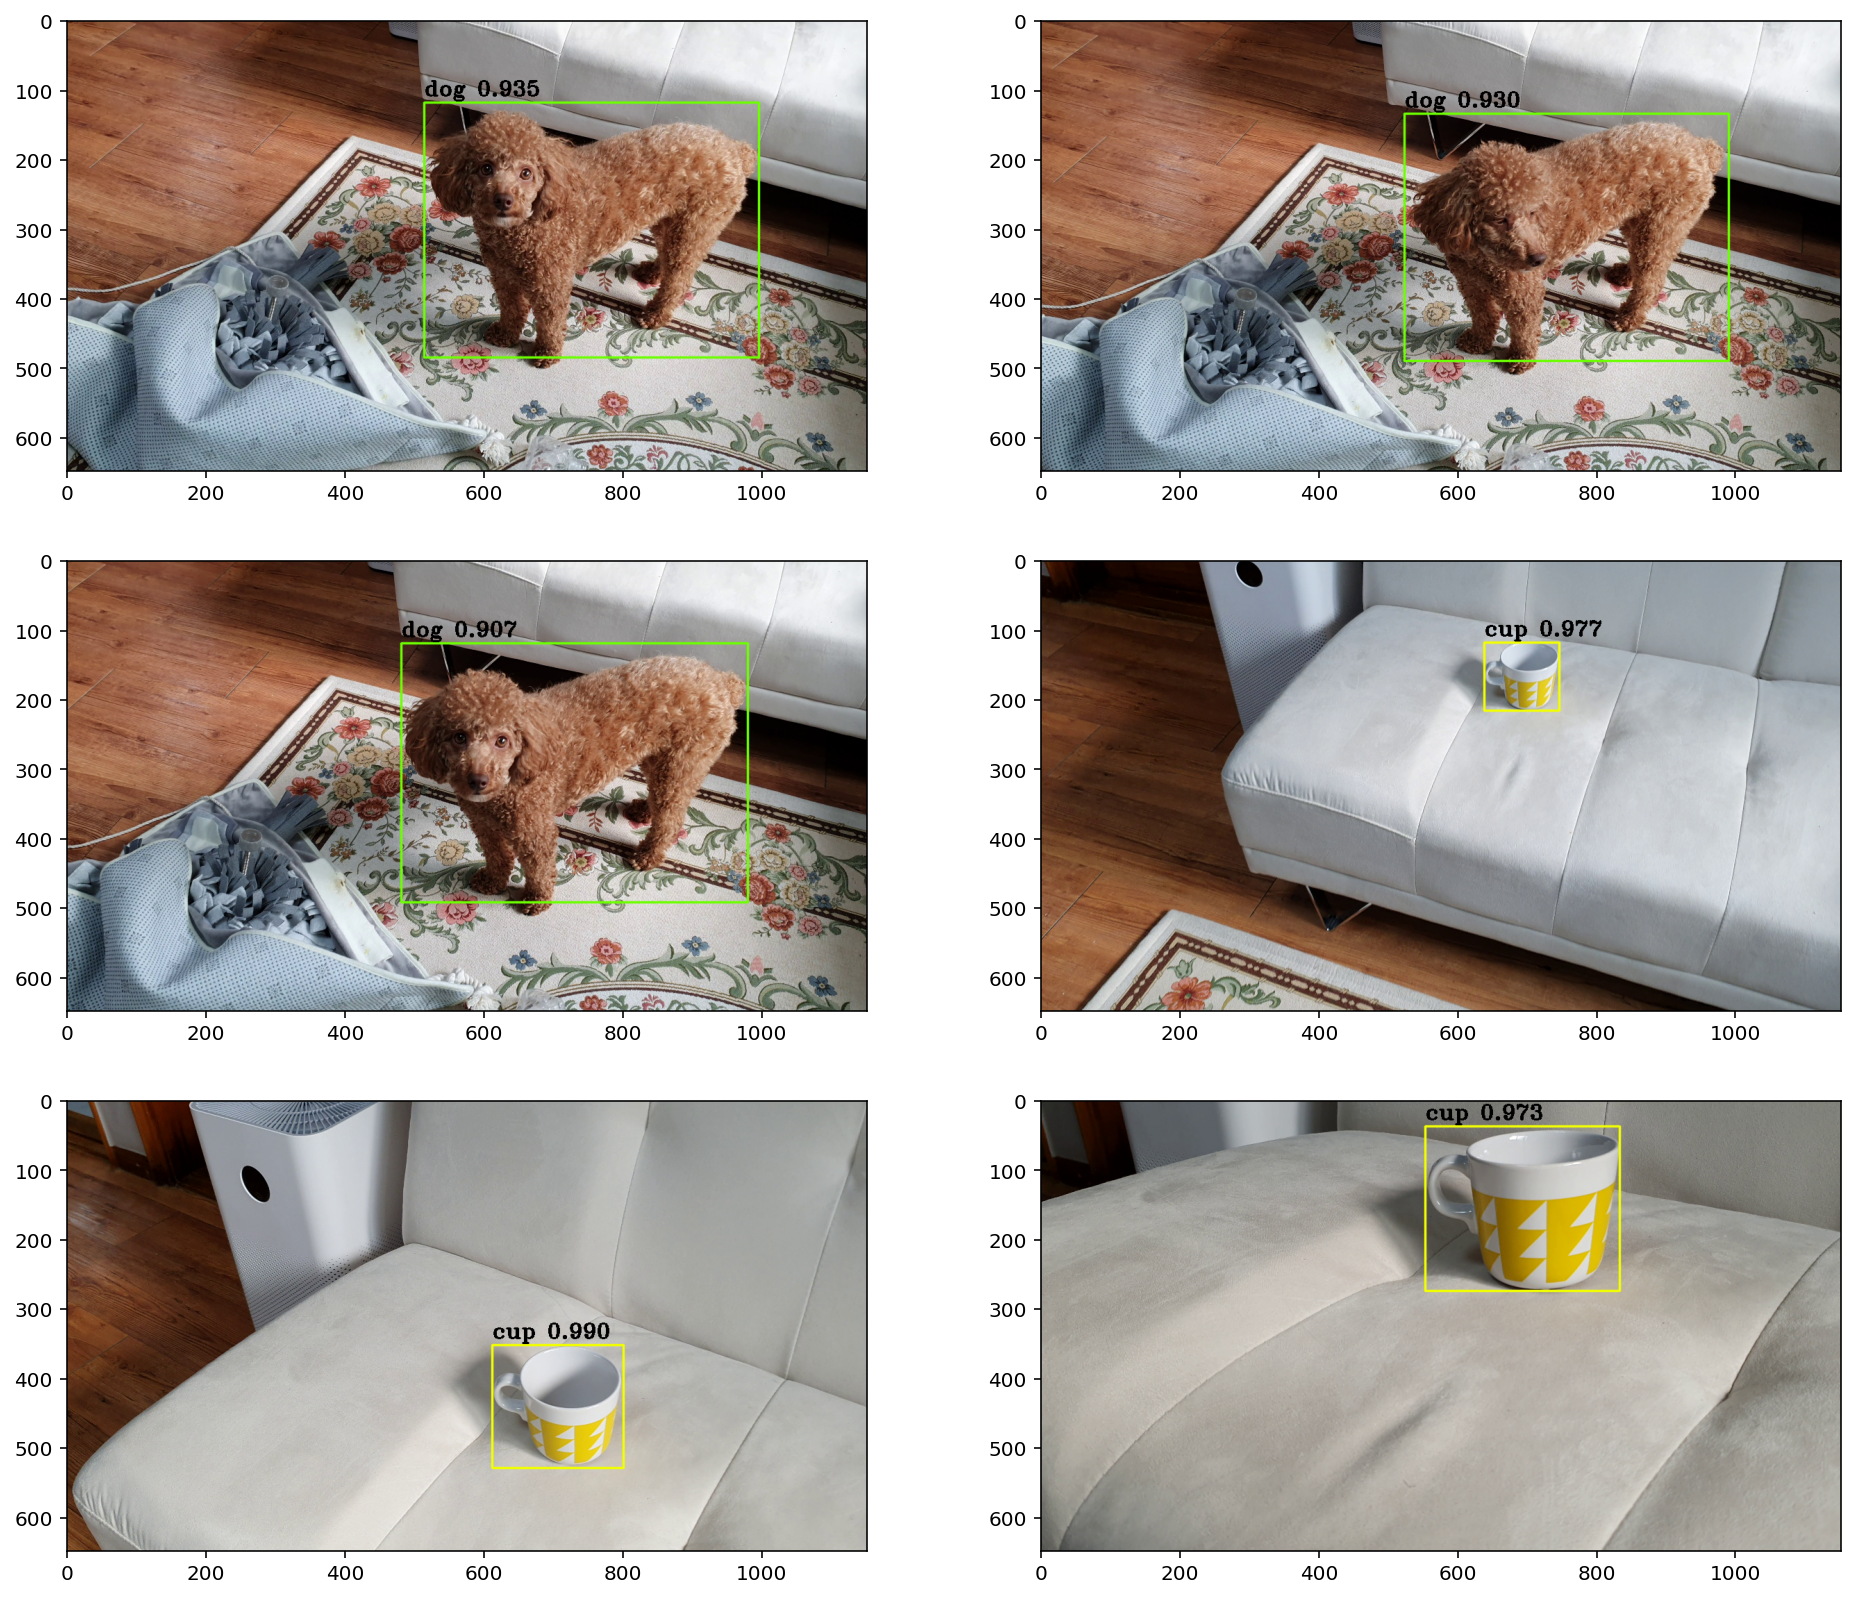

In [19]:
def draw_caption(image, box, caption): ##tag를 넣어주는 함수 
    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_TRIPLEX, 1, (0, 0, 0), 2)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_TRIPLEX, 1, (0, 0, 0), 1)
    #cv2.putText(image,text,org(시작문자 출력 위치=좌측하단), fontFace,fontscale,color,thickness) 


fig = plt.figure(figsize=(16, 24))
for idx, frame in enumerate(frames):
    input_image = frame.copy()
    input_image = preprocess_image(input_image)
    input_image, scale = resize_image(input_image) #preprocess_image, resize_image를 통해 frame 전처리

    boxes, scores, labels = model.predict_on_batch(np.expand_dims(input_image, axis=0)) #RetinaNet의 predict_on_batch를 통해서 box,score,label 반환

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    boxes /= scale
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < 0.7:
            break
        color = label_color(label)

        b = box.astype(int)
        draw_box(frame, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(frame, b, caption)

    fig.add_subplot(5, 2, idx + 1)
    plt.imshow(frame)


plt.show()